In [1]:
from apportionment import *

# for i in range(10):
#     raw2visualisable(f"1m-2023multiTEST{i}.csv", weighted=False)

# for i in range(10):
#     print(f'starting {i}')
#     raw2visualisable(f"1m-2023multiTEST{i}.csv", weighted=False, multi=True)
#     print(f'finished {i}')


In [9]:
csv_files = [f"./vis_data/unweighted-vis-1m-2023multiTEST{i}.csv" for i in range(10)]

combined_df = pd.concat([pd.read_csv(f) for f in csv_files])

averaged_df = combined_df.groupby(["samples", "proportion"]).mean().reset_index()

averaged_df.to_csv("./vis_data/vis-1m-2023multiTOTALsep.csv", index=False)

print("Compression complete")

Compression complete


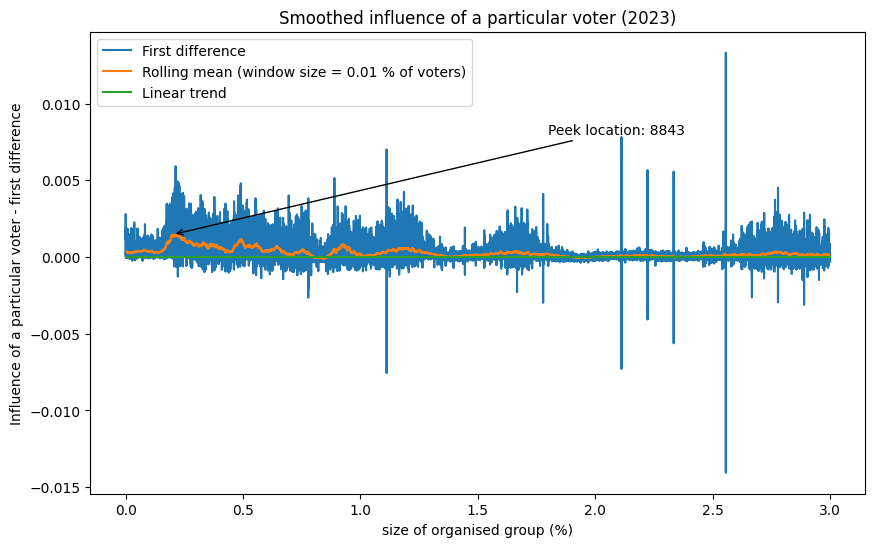

In [11]:
df = pd.read_csv("./vis_data/vis-1m-2023multiTOTAL.csv")

x_values = (df['samples'] / 1000000) * 100
y_values = df['diff']
y_vals =  y_values - (3 * x_values)

y_deriv = y_vals.diff()
y_rolling = y_deriv.rolling(window=100, center=True).mean()

x = np.arange(0, 4)
y = 3 * x

plt.figure(figsize=(10, 6))

plt.plot(x_values, y_deriv, '-', markersize=1, label="First difference")
plt.plot(x_values, y_rolling, '-', markersize=1, label="Rolling mean (window size = 0.01 % of voters)")
plt.plot(x, y * 0, label='Linear trend')

plt.xlabel('size of organised group (%)')
plt.ylabel('Influence of a particular voter - first difference')
plt.title('Smoothed influence of a particular voter (2023)')

plt.legend()

max_index = y_rolling.idxmax()
plt.annotate(f'Peek location: {int(max_index * (4388872 / 1000000))}', xy=(x_values[max_index], y_rolling[max_index]),
                xytext=(1.8, 0.008),
                arrowprops=dict(facecolor='black', arrowstyle='->'))


plt.show()

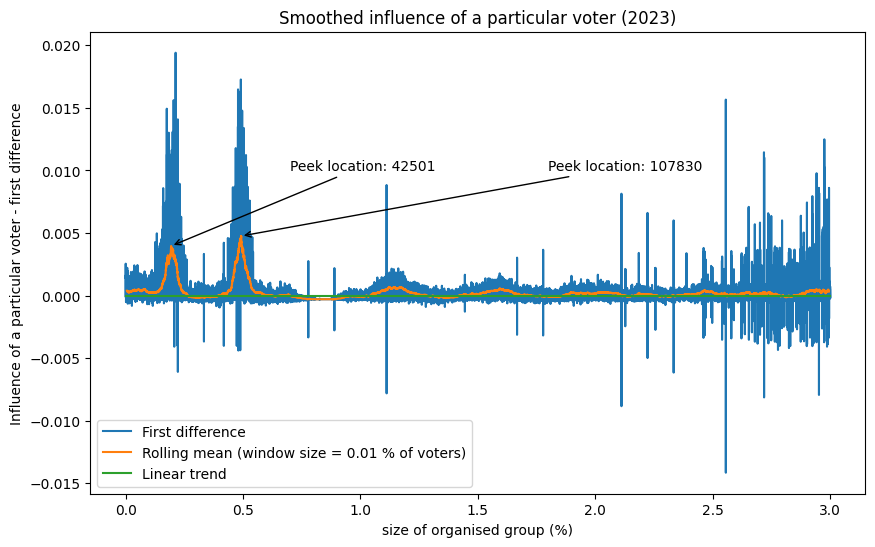

In [16]:
df = pd.read_csv("./vis_data/vis-1m-2023multiTOTALsep.csv")
df = df[df['proportion'] == 90]

x_values = (df['samples'] / 1000000) * 100
y_values = df['diff']
y_vals =  y_values - (3 * x_values)

y_deriv = y_vals.diff()
y_rolling = y_deriv.rolling(window=100, center=True).mean()

x = np.arange(0, 4)
y = 3 * x

plt.figure(figsize=(10, 6))

plt.plot(x_values, y_deriv, '-', markersize=1, label="First difference")
plt.plot(x_values, y_rolling, '-', markersize=1, label="Rolling mean (window size = 0.01 % of voters)")
plt.plot(x, y * 0, label='Linear trend')

plt.xlabel('size of organised group (%)')
plt.ylabel('Influence of a particular voter - first difference')
plt.title('Smoothed influence of a particular voter (2023)')

plt.legend()

# Annotate the maximum indexes on the plot
max_index = y_rolling.idxmax()
plt.annotate(f'Peek location: {int(max_index * (4388872 / 1000000))}', xy=(x_values[max_index], y_rolling[max_index]),
                xytext=(1.8, 0.01),
                arrowprops=dict(facecolor='black', arrowstyle='->'))

max_index = y_rolling[:3000].idxmax()
plt.annotate(f'Peek location: {int(max_index * (4388872 / 1000000))}', xy=(x_values[max_index], y_rolling[max_index]),
                xytext=(0.7, 0.01),
                arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.show()